# О наборе данных

### Контекст
Компаниям-эмитентам кредитных карт важно иметь возможность распознавать мошеннические транзакции, чтобы с клиентов не взималась плата за товары, которые они не покупали.

### Содержание
Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года держателями карт из Европы.

В этом наборе данных представлены транзакции, произошедшие за два дня. 492 из 284 807 транзакций мошеннические. Набор данных сильно несбалансирован, на положительный класс (мошеннические транзакции) приходится 0,172% всех транзакций.

Набор данных содержит только числовые входные переменные, которые являются результатом преобразования PCA (Principal Component Analysis). К сожалению, по соображениям конфиденциальности невозможно предоставить исходные характеристики и дополнительную справочную информацию о данных. Характеристики V1, V2, … V28 являются основными компонентами, полученными с помощью PCA, помимо них есть Time, Amount и Class:

* Time содержит время в секундах, прошедшие между текущей транзакцией и первой транзакцией в наборе данных.

* Amount представляет собой сумму транзакции, которую можно использовать для обучения с учетом затрат в зависимости от примера.

* Class, - значение в этом столбце показывает является ли транзакция мошеннической.

# Импорт библиотек:

In [51]:
import pandas as pd
import sklearn.model_selection as msl

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Импорт данных

In [52]:
df = pd.read_csv('creditcard.csv')

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Первым делом стоит проверить что среди записей нет "бракованных", то есть с пустыми ячейками, поскольку их невозможно использовать, для этого сложим все пустые значения в таблице.

Также проверим количество продублированных записей и удалим их.

In [53]:
empty = df.isna().sum().sum()

df_with_duplicates = len(df)
df.drop_duplicates(inplace=True)
duplicates = df_with_duplicates - len(df)

print('В таблице', empty, 'пустых записей.')
print('Из таблицы удалено', duplicates, 'продублированных записей.')

В таблице 0 пустых записей.
Из таблицы удалено 1081 продублированных записей.


Сборщиками этого набора данных уже было замечено, что набор сильно несбалансирован, поскольку мошеннических транзакций намного меньше чем обычных. Для такого набора данных в качестве метрики, например, нельзя использовать самую простую из них - Accuracy, то есть долю правильных ответов алгоритма. Для данного набора данных эта метрика может показать для алгоритма, никогда не помечающего мошеннические транзакции, результат лучший чем для того, который отлавливает хотя бы часть мошеннических транзакций.

Построим матрицу корреляции для параметров задачи. В матрице корреляции для каждой пары данных из набора посчитан коэффициент корреляции Пирсона, показывающий насколько зависимость между данными близка к линейной.

<Axes: >

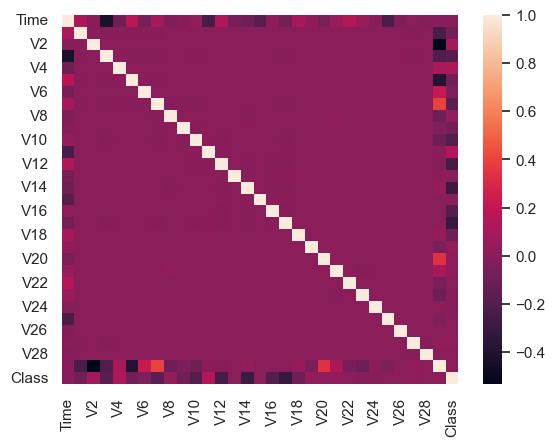

In [54]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix)

Можно видеть что параметры V1-V28 между собой никак не связаны, но имеют слабо выраженную зависимость от Time, Amount и Class.

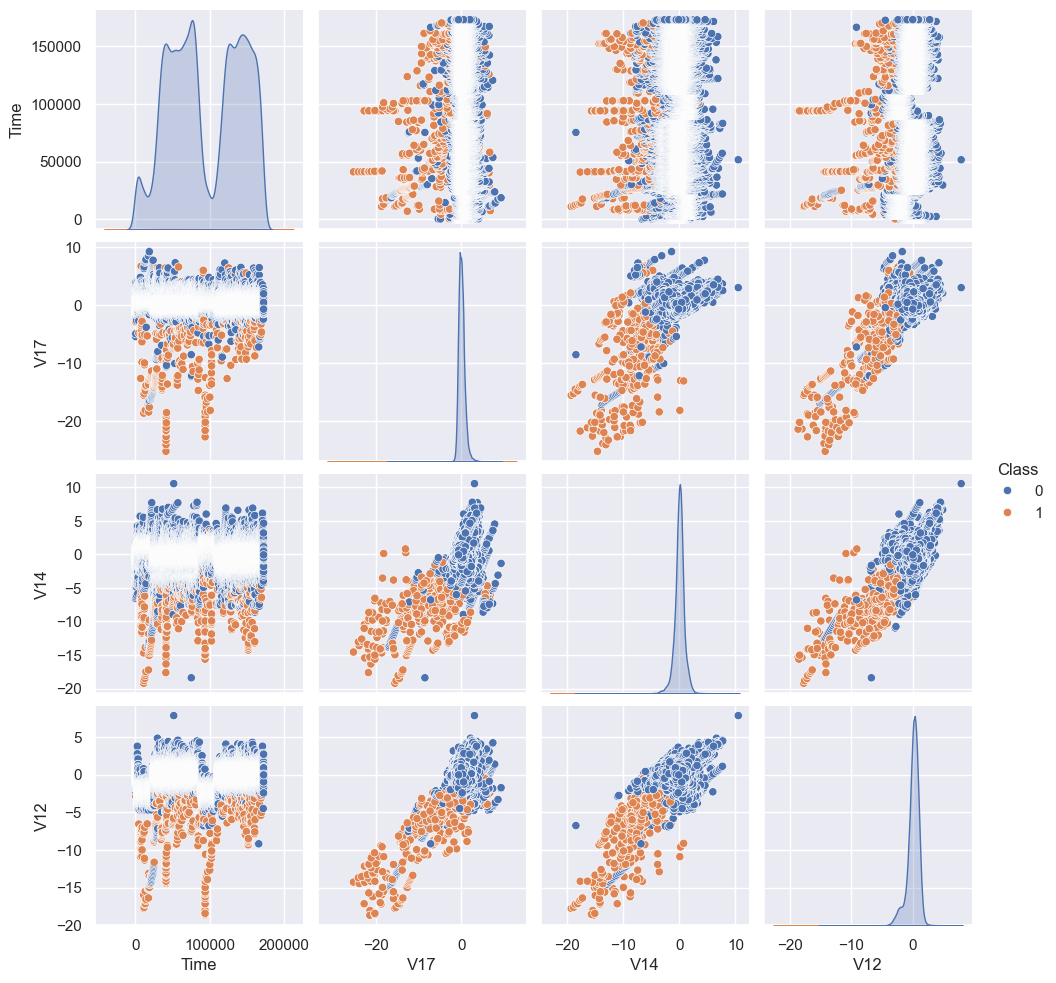

In [55]:
sns.set()
subset = df[['Time', 'V17', 'V14', 'V12', 'Class']]
sns.pairplot(subset, hue='Class')

Глядя на эти графики нельзя уверенно сказать что данные делятся линейно. Конечно можно перебрать все пары признаков, чтоб окончательно убедиться что линейно данные не разделяются нигде (или же обнаружить обратное), но есть риск потратить чрезмерное количество времени.

# Метод логистической регрессии

Для начала попробуем этот метод, поскольку он не допускает перебалансировку данных, а значит проще. Сперва разделим все данные на две выборки: тренировочную и тестовую. На первой обучим модель, на второй протестируем насколько хорошо она работает. Важно чтоб соотношение мошеннических транзакций в выборках сохранялось.

In [56]:
# Отделим все данные от столбца Class
X = df.drop(['Class'], axis=1)
y = df.Class

X_train, X_test, y_train, y_test = msl.train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

print('Проверим что процент мошеннических транзакций в выборках совпадает.')
difference = abs(y_train.sum()/len(y_train)-y_test.sum()/len(y_test))*100
print('Разница составляет', difference, 'процентов.')

Проверим что процент мошеннических транзакций в выборках совпадает.
Разница составляет 0.00014458368676386474 процентов.


Нормализуем данные:

In [57]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93474
           1       0.05      0.90      0.10       156

    accuracy                           0.97     93630
   macro avg       0.53      0.94      0.54     93630
weighted avg       1.00      0.97      0.98     93630



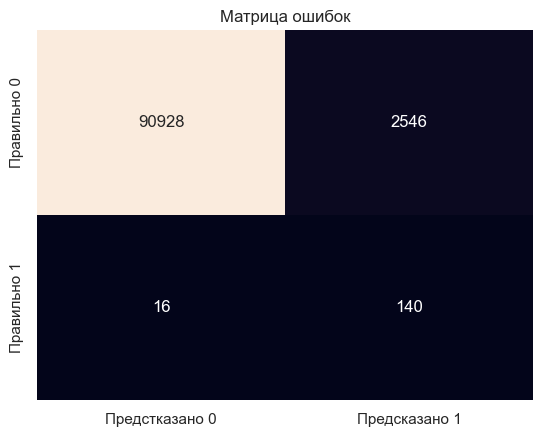

In [58]:
L_Reg = LogisticRegression(class_weight = 'balanced')
L_Reg.fit(X_train_scaled, y_train)
prediction = L_Reg.predict(X_test_scaled)
print(classification_report(y_test, prediction))

Conf_Mat = confusion_matrix(y_test, prediction)

sns.heatmap(Conf_Mat, annot=True, fmt="d", cbar=False,
            xticklabels=['Предстказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

## Результаты обучения модели логистической регрессии

### Precision
Для мошеннических транзакций результат плохой - всего 7%, что говорит о том, что предсказывая их, алгоритм в основном ошибается.

### recall
Показатели recall для обоих классов достаточно высокие, это означает что модель хорошо обнаруживает оба класса.

### f1-score
Видно, что f1-score для класса мошеннических транзакций низкий, что свидетельствует о трудностях модели в их обнаружении.

# Балансировка выборки

Метод логистической регрессии не допускал перебалансировки данных, но далее попробуем методы, которые допускают её, это должно повысить точность алгоритма.

In [59]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_scaled, y_train)
X_test_sampled, y_test_sampled = sampler.fit_resample(X_test_scaled, y_test)

Проверим, не внесло ли семплирование изменения в данные на основе статистик.

In [60]:
X_train_scaled  = pd.DataFrame(data=X_train_scaled)
X_train_sampled = pd.DataFrame(data=X_train_sampled)
X_train_scaled.describe() - X_train_sampled.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,...,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000,-189462.000000
mean,0.127088,1.162184,-1.063430,2.316282,-1.604977,1.078380,0.547690,2.179894,-0.364382,1.177408,...,-0.271442,-0.320221,-0.062892,0.045457,0.095832,-0.057458,-0.066961,-0.300369,-0.139644,-0.063724
std,-0.037553,-1.781654,-1.183009,-3.083588,-1.286067,-2.020629,-0.282805,-3.732704,-2.687549,-1.102135,...,-0.474421,-2.052588,-0.414277,-0.814296,0.062558,-0.312646,-0.001304,-1.396921,-0.384237,-0.018371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.193929,0.896462,-0.272323,2.812219,-0.520351,0.730177,0.673449,1.991611,-0.001044,1.508726,...,-0.031433,-0.072460,0.000018,0.121231,0.101694,-0.011727,-0.084256,-0.022456,0.004523,0.017137
50%,0.064643,0.380026,-0.546268,1.039509,-0.949141,0.250155,0.294776,0.560782,-0.106667,0.606701,...,-0.118173,-0.230879,-0.063565,0.032513,0.065419,-0.069216,-0.085769,-0.135983,-0.073750,0.015370
75%,0.051057,0.130802,-1.205440,0.453236,-2.421475,0.063297,0.271899,0.224498,-0.414771,0.394424,...,-0.390458,-0.589282,-0.111330,-0.073588,0.113486,-0.091800,-0.228034,-0.928192,-0.431923,-0.091194
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Видно, что после семплирования повысилась дисперсия.

# Метод случайного леса

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     93474
           1       1.00      0.73      0.84     93474

    accuracy                           0.87    186948
   macro avg       0.89      0.87      0.86    186948
weighted avg       0.89      0.87      0.86    186948



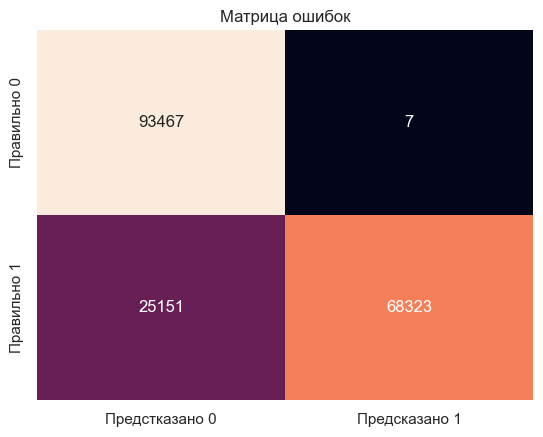

In [61]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train_sampled, y_train_sampled)
prediction = random_forest.predict(X_test_sampled)
print(classification_report(y_test_sampled, prediction))

Conf_Mat = confusion_matrix(y_test_sampled, prediction)

sns.heatmap(Conf_Mat, annot=True, fmt="d", cbar=False,
            xticklabels=['Предстказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

Модель, обученную на семплированных данных применим к исходной выборке.

c:\Users\mike\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93474
           1       0.87      0.69      0.77       156

    accuracy                           1.00     93630
   macro avg       0.93      0.84      0.88     93630
weighted avg       1.00      1.00      1.00     93630



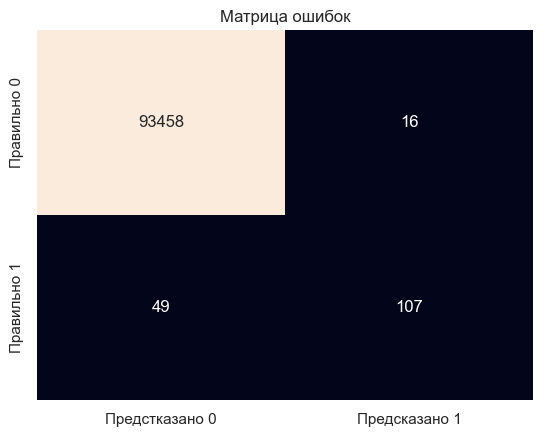

In [62]:
prediction = random_forest.predict(X_test)
print(classification_report(y_test, prediction))

Conf_Mat = confusion_matrix(y_test, prediction)

sns.heatmap(Conf_Mat, annot=True, fmt="d", cbar=False,
            xticklabels=['Предстказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

# Метод k соседей

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     93474
           1       1.00      0.79      0.88     93474

    accuracy                           0.89    186948
   macro avg       0.91      0.89      0.89    186948
weighted avg       0.91      0.89      0.89    186948



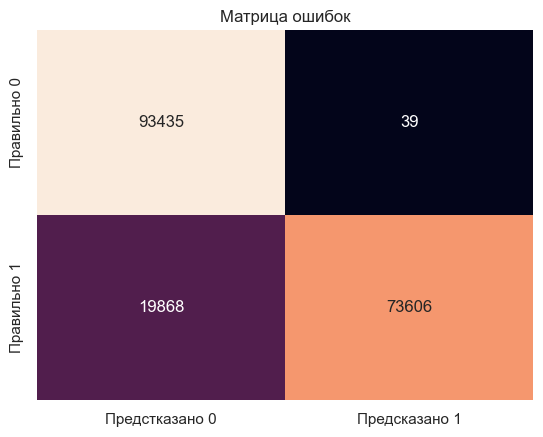

In [63]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier(n_neighbors=3)
k_neighbors.fit(X_train_sampled, y_train_sampled)
prediction = k_neighbors.predict(X_test_sampled)
print(classification_report(y_test_sampled, prediction))

Conf_Mat = confusion_matrix(y_test_sampled, prediction)

sns.heatmap(Conf_Mat, annot=True, fmt="d", cbar=False,
            xticklabels=['Предстказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

Модель, обученную на семплированных данных применим к исходной выборке.

c:\Users\mike\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93474
           1       1.00      0.01      0.01       156

    accuracy                           1.00     93630
   macro avg       1.00      0.50      0.51     93630
weighted avg       1.00      1.00      1.00     93630



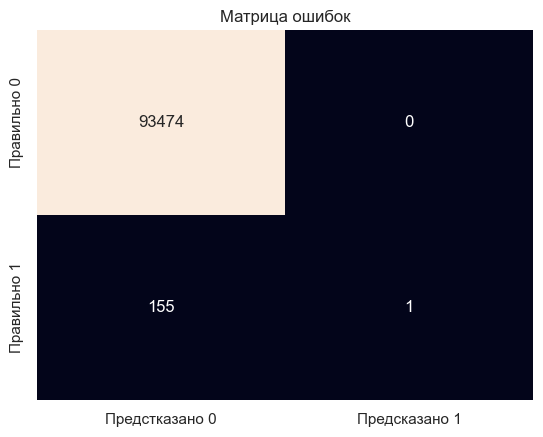

In [64]:
prediction = k_neighbors.predict(X_test)
print(classification_report(y_test, prediction))

Conf_Mat = confusion_matrix(y_test, prediction)

sns.heatmap(Conf_Mat, annot=True, fmt="d", cbar=False,
            xticklabels=['Предстказано 0', 'Предсказано 1'],
            yticklabels=['Правильно 0', 'Правильно 1'])


plt.title('Матрица ошибок')
plt.show()

На исходной выборке такая модель "не видит" мошеннических транзакций, о чем говорит низкий recall = 0.01

In [65]:
results_table = pd.DataFrame({'Алгоритм': ['Логистическая регрессия',
                                            'Сл. Лес на семплированной выборке',
                                            'Сл. Лес на стартовой выборке',
                                            'К соседей на семплированной выборке',
                                            'К соседей на стартовой выборке'], 
                              'precision for 0': [1, 0.79, 1, 0.82, 1],
                              'recall for 0': [0.97, 1, 1, 1, 1],
                              'f1-score for 0': [0.99, 0.88, 1, 0.9, 1],
                              'precision for 1': [0.05, 1, 0.87, 1, 1],
                              'recall for 1': [0.9, 0.73, 0.69, 0.79, 0.01],
                              'f1-score for 1': [0.1, 0.84, 0.77, 0.88, 0.01]})

results_table

,Алгоритм,precision for 0,recall for 0,f1-score for 0,precision for 1,recall for 1,f1-score for 1
0,Логистическая регрессия,1.00,0.97,0.99,0.05,0.90,0.10
1,Сл. Лес на семплированной выборке,0.79,1.00,0.88,1.00,0.73,0.84
2,Сл. Лес на стартовой выборке,1.00,1.00,1.00,0.87,0.69,0.77
3,К соседей на семплированной выборке,0.82,1.00,0.90,1.00,0.79,0.88
4,К соседей на стартовой выборке,1.00,1.00,1.00,1.00,0.01,0.01


# Выводы

1. После пересемплирования данных, показатели улучшились.

2. Метод К-соседей показал себя лучше метода случайного леса (если судить по их результатам на семплированной выборке).

3. Модели, обученные на семплированных выборках, на стартовой выборке показали хорошие результаты в безошибочном обнаружении обыкновенных транзакций. Показатели, относящиеся к обнаружению мошеннических транзакций же оказывались ниже чем аналогичные если модель работала с семплирвоанными данными. Для метода случайного леса разница f1-score для обнаружения мошеннических транзакций составила 0.07, а для метода К соседей целых 0.87